# XArray example of _load_by_step_ _accessor_ evaluation

In this notebook we use and compare the _accessor_ _**load_by_step()**_ with the _xarray_ built in function _**load()**_ when accessing data through a remote server. To do so, we apply this function in a [HYCOM](https://www.hycom.org/) model output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time

In [2]:
import _load_by_step

In [3]:
def convert_to_360(lon):
    return float(np.remainder(lon + 360, 360))

In [4]:
###File Location and Domain Definition
url = "https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0"
ds = xr.open_dataset(url, drop_variables="tau")

### Domain Specification
lonmin=-54
lonmax=-31
latmin=-36
latmax=7
selvar = 'water_u'

da = ds[selvar].sel(lon=slice(convert_to_360(lonmin), convert_to_360(lonmax)), lat=slice(latmin,latmax))

In [5]:
unit = 1e9
print(f'The present dataset is about {np.round(da.size/unit)}GB in size')
print(f'The amount of data present in a single level is about {da.sel(depth=0).size/unit}GB')

The present dataset is about 208.0GB in size
The amount of data present in a single level is about 5.18907456GB


In [6]:
da2 = da.sel(depth=0,time=slice("2024-01-01", "2024-01-10"))
da2

<xarray.DataArray 'water_u' (time: 80, lat: 1076, lon: 288)> Size: 99MB
[24791040 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 9kB -36.0 -35.96 -35.92 -35.88 ... 6.88 6.92 6.96 7.0
  * lon      (lon) float64 2kB 306.0 306.1 306.2 306.2 ... 328.8 328.9 329.0
  * time     (time) datetime64[ns] 640B 2024-01-01 ... 2024-01-10T21:00:00
    depth    float64 8B 0.0
Attributes:
    _CoordinateAxes:  time depth lat lon 
    long_name:        Eastward Water Velocity
    standard_name:    eastward_sea_water_velocity
    units:            m/s
    NAVO_code:        17

In [7]:
da2._in_memory

False

In [8]:
da3 = da2.lbs.load_by_step(time=100)

Donwloading '49.6MB' of 'water_u' between time=[2024-01-01T00:00:00.000000000, 2024-01-10T21:00:00.000000000]: 100%|██████████| 1/1 [00:12<00:00, 12.41s/it]


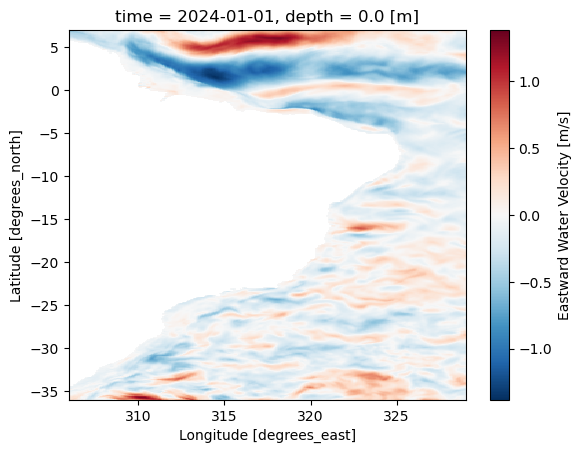

In [9]:
da3[0].plot()

In [10]:
number_of_days = [10,100,250,500,1000,1500]

In [11]:
req_time_load = []

for i in range(len(number_of_days)):
    ds_load = da.sel(depth=0).isel(time=np.arange(0,number_of_days[i]))

    try:
        st_time_load = time.time()
        ds2_load = ds_load.load()
        ex_time_load = time.time()
        req_time_load.append(ex_time_load-st_time_load)
    except:
        print(f"Not able to compute {number_of_days[i]} days, an error occurred")
        req_time_load.append(np.nan)

    del ds_load,ds2_load

In [12]:
req_time_lbs = []

for i in range(len(number_of_days)):
    ds_lbs = da.sel(depth=0).isel(time=np.arange(0,number_of_days[i]))
    if number_of_days[i]<=10:
        stps = int(number_of_days[i])
    else:
        stps = int(number_of_days[i]/10)
        
    st_time_lbs = time.time()
    ds2_lbs = ds_lbs.lbs.load_by_step(time=stps)
    ex_time_lbs = time.time()

    req_time_lbs.append(ex_time_lbs-st_time_lbs)

    del ds_lbs,ds2_lbs

Donwloading '6.2MB' of 'water_u' between time=[2018-12-04T12:00:00.000000000, 2018-12-05T15:00:00.000000000]: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
Donwloading '6.2MB' of 'water_u' between time=[2018-12-15T18:00:00.000000000, 2018-12-16T21:00:00.000000000]: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]
Donwloading '15.5MB' of 'water_u' between time=[2019-01-01T15:00:00.000000000, 2019-01-04T15:00:00.000000000]: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]
Donwloading '31.0MB' of 'water_u' between time=[2019-01-29T21:00:00.000000000, 2019-02-05T00:00:00.000000000]: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]
Donwloading '62.0MB' of 'water_u' between time=[2019-03-27T03:00:00.000000000, 2019-04-08T12:00:00.000000000]: 100%|██████████| 10/10 [00:58<00:00,  5.86s/it]
Donwloading '93.0MB' of 'water_u' between time=[2019-05-22T15:00:00.000000000, 2019-06-10T06:00:00.000000000]: 100%|██████████| 10/10 [00:59<00:00,  5.93s/it]


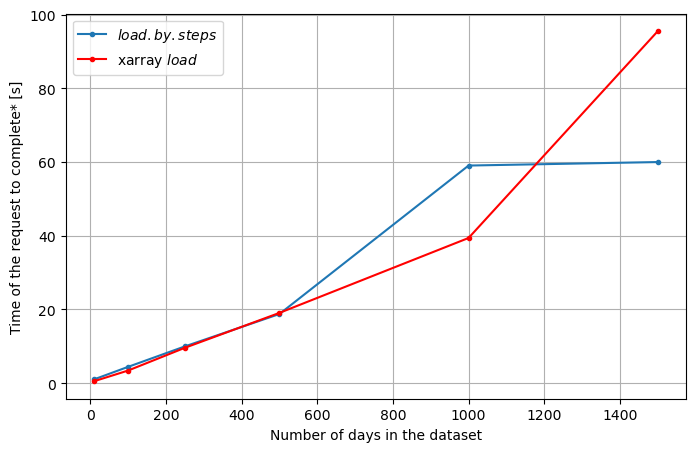

In [14]:
f = plt.figure(figsize=(8,5))
ax = f.add_subplot(1,1,1)

ax.plot(number_of_days,req_time_lbs,marker='.',label="$load.by.steps$")
ax.plot(number_of_days,req_time_load,marker='.',color='r',label='xarray $load$')
ax.set_xlabel("Number of days in the dataset")
ax.set_ylabel("Time of the request to complete* [s]")
ax.grid()
ax.legend(loc='upper left')
f.savefig('intercomparison2.png',facecolor='w',bbox_inches='tight')